In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [56]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [57]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

In [58]:
from tqdm import tqdm

In [59]:
from matplotlib import pyplot as plt
from torch.autograd import Function
%matplotlib inline

In [60]:
np.random.seed = 42

In [122]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit_QAOA():
    def __init__(self,shots):
        self.beta = Parameter('Beta')
        self.gamma = Parameter('Gamma')
        self.delta = Parameter('Delta')
        self.beta2 = Parameter('Beta2')
        self.delta2 = Parameter('Delta2')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(2, 2)
            # add mixer part
            ckt.rx(self.beta, 0)
            ckt.rx(self.beta2, 1)

            # add H_target part, for each Zi Zj do this
            ckt.cx(0,1)
            ckt.rz(-1*self.gamma, 1)
            ckt.cx(0,1)
            ckt.ry(self.delta, 0)
            ckt.ry(self.delta2, 1)
            ckt.measure([0,1],[0,1])
            return ckt

        self.circuit = create_circuit()
    
    def expectation(self, counts, shots, nr_qubits): #calculate expectation for one qubit pair
        expects = 0
        #print(counts)
        for key in counts.keys():
            perc = counts[key]/shots
            #check = Cij*((float(key[i])-1/2)+(float(key[j])-1/2))*perc
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects 
    
    def bind(self,parameters):
        [self.beta, self.beta2, self.gamma, self.delta, self.delta2] = parameters
        #print(self.circuit.data)
        self.circuit.data[0][0]._params = to_numbers(parameters)[0:1]
        self.circuit.data[1][0]._params = to_numbers(parameters)[1:2]
        self.circuit.data[3][0]._params = to_numbers(parameters)[2:3]
        self.circuit.data[5][0]._params = to_numbers(parameters)[3:4]
        self.circuit.data[6][0]._params = to_numbers(parameters)[4:5]
        return self.circuit
 
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        #print(counts)
        return self.expectation(counts, self.shots, 2)    
    
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit_QAOA(shots=10000)
            
        #print(i[0])    
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps

            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))
            result_eps = torch.tensor([exp_value])
            gradient_result = (exp_value - forward_tensor[0][0].item())/eps
            gradient.append(gradient_result)
            
#         print(gradient)
        result = torch.tensor([gradient])
        #print(grad_output.shape)
        #print(result.shape)
        #print(torch.einsum('abc,ac->ab',result.float(),grad_output.float()))
        #print("test tens size", result.float(), grad_output.float())
        return torch.einsum('abc,ac->ab',result.float(),grad_output.float())#result.float() * grad_output.float()

In [ ]:
torch.manual_seed(42)

In [111]:
# x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
x = torch.tensor([[0.3, 0.2, 0.1, 0.1, 0.2]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print(y1)
y1 = torch.abs(y1[0] - 1.0) ** 2
y1.backward()

tensor([[-0.9550, -0.9524]], dtype=torch.float64,
       grad_fn=<TorchCircuitBackward>)


RuntimeError: grad can be implicitly created only for scalar outputs


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


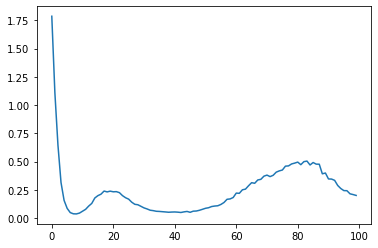

In [123]:
qc = TorchCircuit.apply

def cost(x):
    target = 0.25
    expval = qc(x)
    return torch.abs(qc(x).sum() - target) ** 2, expval

x = torch.tensor([[np.pi/4, np.pi/4, 1.0, 0.5, 0.1]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [125]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

batch_size_train = 1
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:10],idx2[0][0:10])) # concatenate their indices
#idx = idx2
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

Dataset MNIST
    Number of datapoints: 20
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [143]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #x = np.pi*F.tanh(x)
        #print(x)
        x = qc(x)
        x = (x+1)/2
#         print(x)
        #x = torch.cat((x, 1-x), -1)
#        return x
        return F.softmax(x)

In [144]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [145]:
epochs = 100
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()
        #print(data)
        output = network(data)
        print(output[0].data, target)
        loss = F.nll_loss(output, target)
#         print(output)
#         print(output[0][1].item(), target.item())
        #print(loss)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    print(sum(total_loss)/len(total_loss))

/Users/phuembeli/anaconda3/envs/qiskit_develop/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0.5029, 0.4971], dtype=torch.float64) tensor([0])
tensor([0.4989, 0.5011], dtype=torch.float64) tensor([1])
tensor([0.4991, 0.5009], dtype=torch.float64) tensor([0])
tensor([0.4992, 0.5008], dtype=torch.float64) tensor([1])
tensor([0.4995, 0.5005], dtype=torch.float64) tensor([1])
tensor([0.4999, 0.5001], dtype=torch.float64) tensor([1])
tensor([0.4986, 0.5014], dtype=torch.float64) tensor([1])
tensor([0.4995, 0.5005], dtype=torch.float64) tensor([0])
tensor([0.4982, 0.5018], dtype=torch.float64) tensor([1])
tensor([0.5000, 0.5000], dtype=torch.float64) tensor([0])
tensor([0.5026, 0.4974], dtype=torch.float64) tensor([0])
tensor([0.4999, 0.5001], dtype=torch.float64) tensor([1])
tensor([0.5038, 0.4962], dtype=torch.float64) tensor([0])
tensor([0.5005, 0.4995], dtype=torch.float64) tensor([0])
tensor([0.4990, 0.5010], dtype=torch.float64) tensor([0])
tensor([0.5006, 0.4994], dtype=torch.float64) tensor([1])
tensor([0.4999, 0.5001], dtype=torch.float64) tensor([0])
tensor([0.5006

RuntimeError: [json.exception.parse_error.101] parse error at 122: syntax error - invalid literal; last read: '"params": [[N'